In [ ]:
!pip install  -qq langchain-neo4j
!pip install -qq langchain-experimental
!pip install -qq --upgrade certifi
!pip install -qq langchain langchain-community neo4j
from typing  import TypedDict,Dict,Union,Annotated,Sequence,Literal
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage,BaseMessage,ToolMessage
from langchain_groq import ChatGroq
from langchain_community.document_loaders import PyPDFLoader
from langchain_chroma import Chroma
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
from langchain_core.runnables.config import RunnableConfig
from langchain_community.graphs import Neo4jGraph  
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_community.vectorstores import Neo4jVector
from langchain_core.prompts import  ChatPromptTemplate,MessagesPlaceholder
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_neo4j.vectorstores.neo4j_vector import remove_lucene_chars

from langchain_community.graphs import Neo4jGraph


from typing import List
from langchain_core.output_parsers import PydanticOutputParser


import os
load_dotenv()

True

In [19]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]
    unstructured_context:str
    structured_context:str
    question: str
    rewrite_count: int

llm=ChatGroq(model="llama-3.1-8b-instant",temperature=0)
pdf_path="MSME_Schemes_English_0.pdf"


#file_not_found_debug
if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"File Not Found! :{pdf_path}")

pdf=PyPDFLoader(pdf_path)

#pdf_loader_check
try:
    pages=pdf.load()
    print(f"PDF has been loaded and has {len(pages)} pages")
except Exception as e:
    print(f"Error Loading PDF: {e}")
    raise 

PDF has been loaded and has 266 pages


VECTOR DATABASE 

In [77]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=150
)
page_split=text_splitter.split_documents(pages)

req_dir=r"D:\personal\OneDrive\Desktop\langgraph"
colection_name="resume"

#dir_not_found_debug
if not os.path.exists(req_dir):
    os.makedirs(req_dir)

class LocalEmbeddings:
    def __init__(self, model_name):
        # This uses your ALREADY INSTALLED sentence-transformers
        self.model = SentenceTransformer(model_name)
    
    def embed_documents(self, texts):
        # This translates LangChain's request into the .encode() method
        return self.model.encode(texts).tolist()
    
    def embed_query(self, text):
        # This handles a single search query
        return self.model.encode(text).tolist()
    
embeddings = LocalEmbeddings('all-MiniLM-L6-v2')

try:
        vectorstore = Chroma(
        persist_directory="./semantic_history_db", 
        embedding_function=embeddings,
        collection_name="chatLTM_history"
)
   
except Exception as e:
        print(f"Error setting up Chroma DB: {str(e)}")
        raise


###        VECTOR DATABSE RELATED SEARCH        ###

import uuid
import datetime

### ADD CHAT HISTORY(SESSION) IN DATABSE ###
def add_to_vectordb(session_id,session_list):
    """Takes session list which gets out of sliding window and add to our database."""
    formatted_txt="\n".join( f"{msg.type}:{msg.content}" for msg in session_list )
    mem_id=str(uuid.uuid4())
    vectorstore.add_texts(
        texts=[formatted_txt],
        ids=[mem_id],
        metadatas=[{
            "session_id":session_id,
            "timestamp":datetime.datetime.now().isoformat(),
            "type":"chat_chunk"
        }]
    )    


### RETRIEVE FROM DATABASE PAST CONTEXT ###
def retrieve_past_context(state: AgentState):
        """Function returns most semantically similar past refrences """
        user_input = state["messages"][-1].content

        docs=vectorstore.similarity_search(user_input,k=2)
        context="\n---\n".join([doc.page_content for doc in docs])
        
        state["unstructured_context"] = context
        return state

## UPDATE SUMMARY TAKES OLD SUMMARY AND NEW CHAT HISTORY AND UPDATE ###
def update_summary(old_memory:str,update_context:list)->str:
    """Updates conversation summary using a LLM.
     Args:
        old_memory: Previous summary of the conversation
        update_context: Recent messages to incorporate into summary
        
    Returns:
        Updated summary string
    """
    summary_llm=ChatGroq(
        model="llama-3.1-8b-instant",
        temperature=0.3
    )
    
    recent_context = ""
    for msg in update_context:  
        if isinstance(msg, HumanMessage):
            recent_context += f"User: {msg.content}\n"
        elif isinstance(msg, AIMessage):
            recent_context += f"Assistant: {msg.content[:200]}\n"  

    prompt_llm=f"""You are a conversation summarizer. 
    PREVIOUS SUMMARY: {old_memory}
    
    NEW RECENT CHAT:
    {recent_context}

    Create a NEW summary that takes important features from previous summary and add them to new summary:
    1. User preferences,facts about user
    1. Captures the main topic the user is learning
    2. Notes key questions asked and concepts covered
    3. Identifies any struggles or confusion points
    4. Keeps track of what the student has accomplished
    5. Maximum 3-4 sentences
    """
    try:
        new_response=summary_llm.invoke([HumanMessage(content=prompt_llm)])
       
        return new_response.content.strip()
            
    except Exception as e:
            print(f" Summary update failed: {e}")
            return old_memory



In [95]:


def call(state: AgentState):
  
    prompt_template = ChatPromptTemplate.from_messages([
        
       (
    "system",
    """
You are an empathetic and thoughtful AI tutor.

Guidelines:
- Use only the information explicitly provided in the context below.
- If a detail is missing or unclear, clearly state that you don’t have that information yet.
- Do not assume or infer personal details unless they are present in context.
- Access to tools does not guarantee information exists.

Answering style:
- Be warm, clear, and honest.
- Avoid speculation.
- Prefer correctness over completeness.

STRUCTURED CONTEXT:
{structured_context}

UNSTRUCTURED CONTEXT:
{unstructured_context}
"""
),
       MessagesPlaceholder(variable_name="messages")
    ])

    # 2. Extract state (Memory Management)
    messages = state["messages"]
    struct_context = state.get("structured_context") or ""
    unstructured_context = state.get("unstructured_context") or ""


    try:
        # We pass a dictionary where keys match the placeholders in the template
        chain = prompt_template | llm
        response = chain.invoke({
            "structured_context": struct_context,
            "messages": messages,
            "unstructured_context":unstructured_context
        })
        return {"messages": [AIMessage(content=response.content)]}
        
    except Exception as e:
        print(f"Error in LLM invocation: {e}")
        return {"messages": [AIMessage(content="I'm having trouble syncing my memory. Let's try that again.")]}

Knowledge graph 


In [91]:
# Ensure these match the variables from your successful test
kg_conn = Neo4jGraph(
    url=os.getenv("NEO4J_URI"),
    username=os.getenv("NEO4J_USERNAME"),
    password=os.getenv("NEO4J_PASSWORD"),
   
)


llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)
llm_transformer=LLMGraphTransformer(llm=llm)
page_split=text_splitter.split_documents(pages)
graph_documents = llm_transformer.convert_to_graph_documents(page_split[:3])
kg_conn.add_graph_documents(
    graph_documents, 
    baseEntityLabel=True, 
    include_source=True
)

In [ ]:

### KNOWLEDGE BASE MODEL CLASS ###
class KnowledgeConcept(BaseModel):
    """Schema for extracting entities."""
    names: List[str] = Field(
        ...,
        min_items=1,
        max_items=5,  
        description="Extract at most 5 core concepts strictly necessary for retrieval."
    )

### PROMPT ###
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are extracting objects and entities from the text."),
    ("human", "Use the given format to extract information from the following"
    "input:{question}",
    ),
])
entity_chain = prompt | llm.with_structured_output(KnowledgeConcept)

### GENERTAE QUERY FOR KG ###
def generate_full_query(input:str)->str:
    full_query=""
    words=[el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_query+=f"{word}~2 AND "
    full_query+=f"{words[-1]}~2"
    return full_query.strip()


### STRUCTURED RETRIEVER ###
def structured_retriever(state: AgentState)->str:
    result=""
    question =state["question"][:500]
  
    entities=entity_chain.invoke({"question":question})
    for entity in entities.names:
        try:
            response=kg_conn.query(
                #Cyphe_Query
                """ 
                    CALL db.index.fulltext.queryNodes('entity_name_index', $query, {limit: 2})
            YIELD node, score
            OPTIONAL MATCH (node)-[r]->(neighbor)
            OPTIONAL MATCH (neighbor)-[r2]->(node)
            WHERE (neighbor IS NOT NULL AND type(r) <> 'MENTIONS')
               OR (neighbor IS NOT NULL AND type(r2) <> 'MENTIONS')
            RETURN collect(coalesce(node.id,'NULL') + '-' + coalesce(type(r),'NULL') + '->' + coalesce(neighbor.id,'NULL'))
                 + collect(coalesce(neighbor.id,'NULL') + '-' + coalesce(type(r2),'NULL') + '->' + coalesce(node.id,'NULL')) AS output
            LIMIT 50
                """,
                {"query":generate_full_query(entity)},

            )
            result+="\n".join([el['output'] for el in response ])
            
        except Exception as e:
            print(f"Error searching for entity '{entity}': {e}")
    state["structured_context"] = result
    return state
        





In [93]:
### ROUTER CLASS MEMORY ROUTER ###
class MemoryRoute(BaseModel):
    """Routing decision for memory system."""
    
    route: Literal[ "vector_db", "knowledge_graph", "generate"] = Field(
        ...,
        description="Which path to take based on the user's query"
    )
    
    reasoning: str = Field(
        ...,
        description="Brief explanation of why this route was chosen"
    )


tier_1=ChatGroq(model="llama-3.1-8b-instant", temperature=0, max_retries=0)
backup_model = ChatGroq(model="llama-3.1-8b-instant", temperature=0)

router_llm = (
    tier_1
    .with_structured_output(MemoryRoute)
    .with_fallbacks([backup_model.with_structured_output(MemoryRoute)])
)


### MEMORY ROUTER FUNCTION RETURN STR ###
def memory_router(state: AgentState) -> str:
    """
    Memory Router for AI Tutor System 
    Optimized for low-latency, high-accuracy routing decisions.

    Design Principles:
    1. Zero ambiguity - deterministic routing
    2. Minimal token usage - direct and concise
    3. Fast classification - pattern-first approach
    4. Fail-safe defaults - graceful degradation
    """
    rewrite_count = state.get("rewrite_count", 0)
    if rewrite_count > 0  and rewrite_count<2:
        print(f"--- ROUTING REWRITTEN QUERY (Attempt {rewrite_count}) ---")
        user_input = state.get("question")
    else:

        messages = state["messages"]
        user_input = messages[-1].content
    
    # Initialize parser and LLM
    router_prompt="""
You are an intelligent query router for a multi-source AI system.

Your task is to analyze the user's question and decide the SINGLE best source to answer it.

Available routes:

1. "vector_db"
   - Use when the question requires:
     - Information from documents, PDFs, transcripts, manuals, reports, notes
     - Semantic search, similarity matching, or contextual retrieval
     - Long-form or unstructured knowledge
     - Previously indexed content

2. "knowledge_graph"
   - Use when the question requires:
     - Relationships between entities (who, how related, dependencies)
     - Structured facts (dates, quantities, hierarchies)
     - Multi-hop reasoning over connected data
     - Queries like: "how is A related to B", "what depends on X", "list all Y under Z"

3. "generate"
   - Use when the question:
     - Is conceptual, explanatory, or opinion-based
     - Requires reasoning, summarization, or creativity
     - Can be answered from general knowledge
     - Does NOT require external or stored data

Query: {user_input}

Reason: (max 10 words)"""

    try:
      
        decision = router_llm.invoke(router_prompt.format(user_input=user_input))
        model_used = getattr(decision, "response_metadata", {}).get("model_name")
        print(model_used)
        print(f"\n--- ROUTING DECISION: {decision.route} | Reasoning: {decision.reasoning} ---\n")
        return decision.route
        
    except Exception as e:
        print(f" Routing failed, using fallback. Error: {e}")
        return _fallback_routing(user_input)



### FALL_BACK FUNCTION PREVENT FROM FAILURE ###
def _fallback_routing(query: str) -> str:
    """Keyword-based fallback if LLM parsing fails."""
    
    query_lower = query.lower()
    
    # Check for vector DB keywords
    if any(kw in query_lower for kw in [
        "find", "search", "documents", "similar", "show me",
        "retrieve", "look for", "fetch"
    ]):
        
        return "vector_db"
    
    # Check for knowledge graph keywords
    if any(kw in query_lower for kw in [
        "how does", "why does", "relationship", "connected",
        "relate to", "explain", "connection", "cause", "effect"
    ]):
       
        return "knowledge_graph"
    else:
        return "generate"



In [85]:
grader_llm=ChatGroq(model="llama-3.1-8b-instant", temperature=0)

class RelevanceScore(BaseModel):
    """Binary score for context relevance."""
    vector_score: float = Field(description="Is the context_text relevant scale down on scale of 0.0–1.0")
    graph_score:  float = Field(description="Is the graph_data relevant scale down on scale of 0.0–1.0")


grader_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a strict relevance evaluator."),
    ("human", """
Question:
{question}

Vector DB Context:
{vector_docs}

Knowledge Graph Context:
{graph_docs}

Return relevance scores between 0 and 1.
""")
])
grader = grader_prompt|grader_llm.with_structured_output(RelevanceScore)
def grade_and_filter(state: AgentState)->str:
    """
    Decides the next route in the graph.
    MUST return only one of the routing keys.

    """
    try:

        question = state.get("question") or state["messages"][-1].content
        vector_data = state.get("unstructured_context", "")
        graph_data = state.get("structured_context", "")

    # One LLM call to grade both sources
        score = grader.invoke({
            "question": question,
            "vector_docs": vector_data,
            "graph_docs": graph_data
        })
        
    
        rewrite_count = state.get("rewrite_count", 0)
        
         #if neither kg nor vector_db weightage is relevant
        if (
            score.vector_score < 0.4
            and score.graph_score < 0.4
            and rewrite_count < 2
        ):
            state["rewrite_count"] = rewrite_count + 1
            return "rewrite_query" 
        #if kg weightage is more relevant
        if score.graph_score >= 0.7 and score.graph_score > score.vector_score:
            state["unstructured_context"] = ""
            return "generate"
        #if vector_db weightage is more relevant
        if score.vector_score >= 0.6 and score.vector_score > score.graph_score:
            state["structured_context"] = ""
            return "generate"
       
        return "generate"
    except Exception as e:
        print(f"Error in grading & filter . Error: {e}")
        return "generate" 




# Rewriter function
rewriter_llm=ChatGroq(model="llama-3.1-8b-instant", temperature=0)
def rewrite_query(state: AgentState):
    print("---REWRITING QUERY---")
    history = state["messages"]
    # We use the 'question' from state which failed the previous grade
    current_query = state["question"]
    
    # The prompt now uses history to resolve references (e.g. "it", "that", "him")
    # but focuses on the 'question' for the core technical subject.
    system_prompt = """You are a prompt expert for query writting. Rewrite the user's question to be 
    more effective for a Knowledge Graph and Vector search.
    - Resolve pronouns using the chat history.
    - Keep technical terms intact.
    - Output ONLY the improved search string."""

    # Logic to call your ChatGroq model...
    response = rewriter_llm.invoke([
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"History: {history}\n\nQuestion to rewrite: {current_query}"}
    ])

    state["question"] = response.content.strip()
    return state

In [ ]:

### GRAPH CONNECTION ###
agent=StateGraph(AgentState)

agent.add_node("Structured_context",structured_retriever)
agent.add_node("Unstructured_context",retrieve_past_context)

agent.add_node("mdl_call",call)
agent.add_node("router_node", lambda x: x)
agent.add_node("grader_node",lambda x:x)
agent.add_edge(START, "router_node")
agent.add_node("rewrite",rewrite_query)
agent.add_conditional_edges(
    "router_node",
    memory_router,
    {
        
        "vector_db":"Unstructured_context",
        "knowledge_graph":"Structured_context",
        "generate":"mdl_call"
       
    },
)
agent.add_edge("Structured_context","grader_node")
agent.add_edge("Unstructured_context","grader_node")
agent.add_conditional_edges(
    "grader_node",
    grade_and_filter,
    {
        "rewrite_query":"rewrite",
        "generate":"mdl_call"
    }

)
agent.add_edge("rewrite", "Structured_context")
agent.add_edge("rewrite", "Unstructured_context")


agent.add_edge("mdl_call",END)
app=agent.compile()


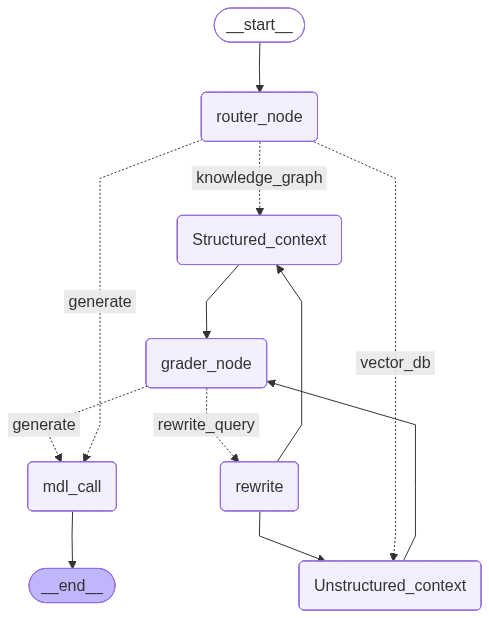

In [87]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

### RUN TIME FOR AGENT ##
session=[]
memory_summary="Conversation just started!"
def run_agent():
    # Generates a short, unique string like: "sess_a1b2c3d4"
    session_id = f"sess_{str(uuid.uuid4())[:8]}"
    global memory_summary,session
    while(True):
        user_input=input("Enter query : " )
        if user_input.lower() in ['exit','quit','done','out','escape']:
            break
      
        message=[SystemMessage(content=f"Current_context:{memory_summary}"),*session[-8:],HumanMessage(content=user_input)]
        res=app.invoke({"messages":message},config={"recursion_limit": 10})
        
        print("\n ....ANSWER.... \n")
        print(res['messages'][-1].content)
     
        session.append(HumanMessage(content=user_input))
        session.append(AIMessage(content=res['messages'][-1].content))

        if(len(session))>10:
            add_to_vectordb(session_id,session)
            memory_summary=update_summary(memory_summary,session)
            session=session[-4:]
            

        



In [88]:
session=[]
memory_summary="Conversation just started!"
def run_agent():
    global memory_summary, session
    session_id = f"sess_{str(uuid.uuid4())[:8]}"
    
    while True:
        user_input = input("Enter query: ")
        if user_input.lower() in ['exit', 'quit', 'done']: break

        # We only pass the CURRENT message. The graph pulls the rest from 'summary'
        active_history = session[-4:]
        input_state = {
            "messages": active_history+[HumanMessage(content=user_input)],
            "unstructured_context": memory_summary ,
            "question":  user_input,  
            "rewrite_count": 0,        
            "structured_context": ""
        }
        
        # Invoke the graph with a recursion limit to prevent runaway loops
        res = app.invoke(input_state, config={"recursion_limit": 10})
        
        answer = res['messages'][-1].content
        print(f"\nUSER_QUERY: {user_input}\n")
        print(f"\n ....ANSWER.... \n{answer}")

        # Phase 2: Update the session history
        session.append(HumanMessage(content=user_input))
        session.append(AIMessage(content=answer))

        # Phase 3: Archive logic
        if len(session) > 10:
            # 1. Archive the oldest 6 messages to VectorDB
            add_to_vectordb(session_id, session[:-4]) 
            
            # 2. Generate a new summary to replace the archived messages
            memory_summary = update_summary(memory_summary, session) 
            
            # 3. Truncate the session to keep tokens low for the next turn
            session = session[-4:]

In [107]:

run_agent()

None

--- ROUTING DECISION: knowledge_graph | Reasoning: Structured facts about MUDRA scheme and loan usage ---

Error searching for entity 'MSME loan': {code: Neo.ClientError.Statement.SyntaxError} {message: Expected exactly one statement per query but got: 2 (line 0, column 0 (offset: 0))
"CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (n:Entity) ON EACH [n.name];"
 ^}
Error searching for entity 'personal credit card debt': {code: Neo.ClientError.Statement.SyntaxError} {message: Expected exactly one statement per query but got: 2 (line 0, column 0 (offset: 0))
"CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (n:Entity) ON EACH [n.name];"
 ^}
Error searching for entity 'MUDRA scheme': {code: Neo.ClientError.Statement.SyntaxError} {message: Expected exactly one statement per query but got: 2 (line 0, column 0 (offset: 0))
"CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (n:Entity) ON EACH [n.name];"
 ^}

USER_QUERY: I want to use my MSME loan to pay off my personal credit card debt from 